In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
dfall1ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot2Ar39*"
dfall2ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot3Ar39*"
dfall3ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot4Ar39*"
dfall4ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

# Load Ar41
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileprefix = "SnapshotAr41*"
dfallar41 = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot2Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot3Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot4Ar39*
...................................................................................................
[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in 117.72 seconds
[Info] Loading 1 files wt prefix:
SnapshotAr41*

[Info] Loaded all Ar41 in 0.02 seconds


In [4]:
ar39_probs = np.array([.9903065, 
                         .0096307, 
                         .0000624,
                         .0000004])    # from normalized probabilities P[k decays | >=1 decays]
ar39_fract_pass_cut = np.array([len(dfall1ar39[dfall1ar39.pedetected>=5])/len(dfall1ar39),
                                len(dfall2ar39[dfall2ar39.pedetected>=5])/len(dfall2ar39),
                                len(dfall3ar39[dfall3ar39.pedetected>=5])/len(dfall3ar39),
                                len(dfall4ar39[dfall4ar39.pedetected>=5])/len(dfall4ar39)])
ar39_weights = [prob*fract for (prob, fract) in zip(ar39_probs, ar39_fract_pass_cut)]

print("[Info] Cut at 5 PE:")
print("\t1 Ar39: Pr: {:.6f}, Pass. Cut 5 PE: {:.6f} %\t=> Weight: {:.8f}".format(ar39_probs[0], ar39_fract_pass_cut[0], ar39_weights[0]/sum(ar39_weights)))
print("\t2 Ar39: Pr: {:.6f}, Pass. Cut 5 PE: {:.6f} %\t=> Weight: {:.8f}".format(ar39_probs[1], ar39_fract_pass_cut[1], ar39_weights[1]/sum(ar39_weights)))
print("\t3 Ar39: Pr: {:.6f}, Pass. Cut 5 PE: {:.6f} %\t=> Weight: {:.8f}".format(ar39_probs[2], ar39_fract_pass_cut[2], ar39_weights[2]/sum(ar39_weights)))
print("\t4 Ar39: Pr: {:.6f}, Pass. Cut 5 PE: {:.6f} %\t=> Weight: {:.8f}".format(ar39_probs[3], ar39_fract_pass_cut[3], ar39_weights[3]/sum(ar39_weights)))
print()
print("\tAr41 produced within 1m: {:.5f} % has 5<=NPE<=60 PE".format(len(dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=60)])/len(dfallar41)))

[Info] Cut at 5 PE:
	1 Ar39: Pr: 0.990306, Pass. Cut 5 PE: 0.087097 %	=> Weight: 0.96570801
	2 Ar39: Pr: 0.009631, Pass. Cut 5 PE: 0.313795 %	=> Weight: 0.03383581
	3 Ar39: Pr: 0.000062, Pass. Cut 5 PE: 0.647117 %	=> Weight: 0.00045211
	4 Ar39: Pr: 0.000000, Pass. Cut 5 PE: 0.908864 %	=> Weight: 0.00000407

	Ar41 produced within 1m: 0.66275 % has 5<=NPE<=60 PE


In [5]:
len(dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)])

7203

In [6]:
dfall4ar39.pedetected.describe()["max"]

42.0

# create dataset
1. Since max detection from 1..4 Ar39 pileups is `42`, we consider only Ar41 events wt `NPE<=50`.
1. We consider a preliminary cut at `5 PE`

We have `7203` events wt `5<=NPE<=50 PE`. Then, we arrange the dataset in the following way:
1. Test Set: 10% (720 instances)
1. Train+Val Sets: 90% (6483 instances)
Then, we create the Ar39 dataset with 1,2,3,4 pileups in the following way:
1. Train+Val Sets: 6483 instances splitted wt weights `[0.30, .30, .20, .20]` for each class of pileups
1. Test Set: all the rest of available data

In [7]:
# consider only instances wt 5<=NPE<=50
dfcut1ar39 = dfall1ar39[(dfall1ar39.pedetected>=5) & (dfall1ar39.pedetected<=50)]
dfcut2ar39 = dfall2ar39[(dfall2ar39.pedetected>=5) & (dfall2ar39.pedetected<=50)]
dfcut3ar39 = dfall3ar39[(dfall3ar39.pedetected>=5) & (dfall3ar39.pedetected<=50)]
dfcut4ar39 = dfall4ar39[(dfall4ar39.pedetected>=5) & (dfall4ar39.pedetected<=50)]
dfcutar41 = dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)]

In [8]:
# remove test data from ar41
n_test_ar41 = round(.10 * len(dfcutar41))
id_ar41 = np.arange(len(dfcutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = dfcutar41.iloc[id_ar41[:n_test_ar41], :], dfcutar41.iloc[id_ar41[n_test_ar41:], :]

# undersample ar39

In [9]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

2.291024923324585


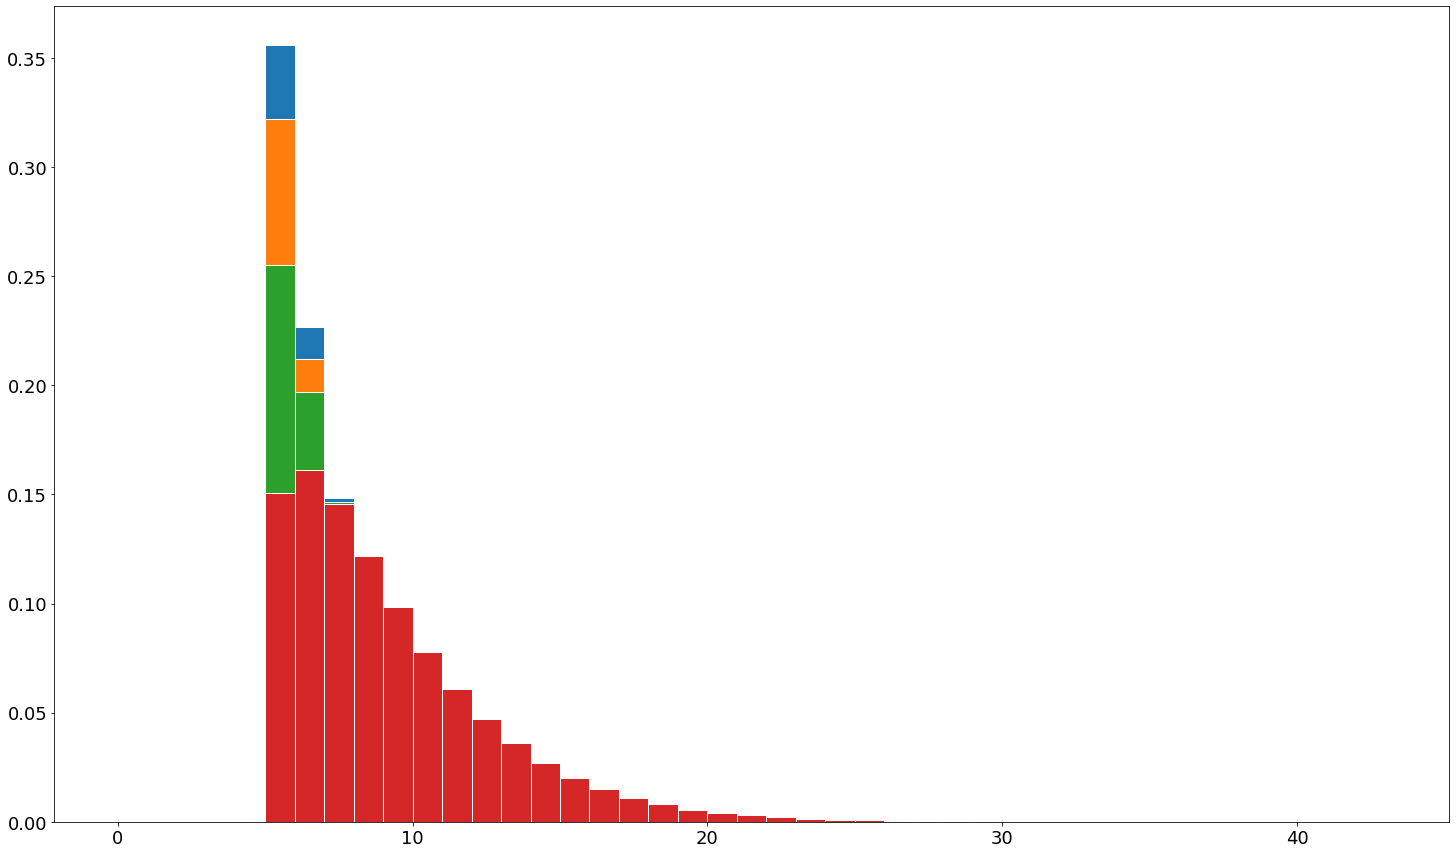

In [10]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_1ar39 = undersample_argon(dfcut1ar39, round(len(train_ar41)*.30), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_2ar39 = undersample_argon(dfcut2ar39, round(len(train_ar41)*.30), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_3ar39 = undersample_argon(dfcut3ar39, round(len(train_ar41)*.20), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_4ar39 = undersample_argon(dfcut4ar39, round(len(train_ar41)*.20), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print(time.time() - init)

In [11]:
# compact ar39 training data
train_ar39 = pd.concat([train_1ar39, train_2ar39, train_3ar39, train_4ar39], axis=0)

# compute features

In [12]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [13]:
# Compute features muon
import time

init = time.time()
df_ar41_feat = pd.DataFrame()
df_ar41_feat["PEDetected_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["StdNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar41_feat["SpatialStd_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["StdNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar41_feat["SpatialStd_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_tot"] = df_ar41_feat["PEDetected_inner"] + df_ar41_feat["PEDetected_outer"]
df_ar41_feat["NActiveSlices_tot"] = df_ar41_feat["NActiveSlices_inner"] + df_ar41_feat["NActiveSlices_outer"]
df_ar41_feat["MeanNPEActive_tot"] = df_ar41_feat["PEDetected_tot"] / df_ar41_feat["NActiveSlices_tot"]
df_ar41_feat = df_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
df_ar39_feat = pd.DataFrame()
df_ar39_feat["PEDetected_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["StdNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar39_feat["SpatialStd_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["StdNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar39_feat["SpatialStd_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_tot"] = df_ar39_feat["PEDetected_inner"] + df_ar39_feat["PEDetected_outer"]
df_ar39_feat["NActiveSlices_tot"] = df_ar39_feat["NActiveSlices_inner"] + df_ar39_feat["NActiveSlices_outer"]
df_ar39_feat["MeanNPEActive_tot"] = df_ar39_feat["PEDetected_tot"] / df_ar39_feat["NActiveSlices_tot"]
df_ar39_feat = df_ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.825 sec
Compute Mu Outer features: 1.183 sec
Compute combined features: 0.005 sec
Compute Ar39 Inner features: 1.116 sec
Compute Ar39 Outer features: 1.199 sec
Compute combined features: 0.003 sec


# train+validate models

In [14]:
# ml imports
import time
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix as cv

In [15]:
# prepare data for training
df_ar39_feat["y"] = 0
df_ar41_feat["y"] = 1
# data preparation
data = pd.concat([df_ar39_feat, df_ar41_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)
# K-Fold X-validation
n_folds = 5    # each time 80% training, 20% validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123456789)

# create simple dtree
max_depth = 5
criterion = "entropy"
clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
# k-fold cross val
accuracies, precisions, recalls, f1s= [], [], [], []
iteration = 0
for train_ids, val_ids in kf.split(X):
    iteration = iteration + 1
    X_train, X_val = X[train_ids], X[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
print("[Info] Training Simple DTree: max depth: {}, criterion: {}".format(max_depth, criterion))
print("[Info] Avg Accuracy: {}".format(sum(accuracies)/len(accuracies)))
print("[Info] Avg Precision: {}".format(sum(precisions)/len(precisions)))
print("[Info] Avg Recall: {}".format(sum(recalls)/len(recalls)))
print("[Info] Avg F1: {}".format(sum(f1s)/len(f1s)))

[Info] Training Simple DTree: max depth: 5, criterion: entropy
[Info] Avg Accuracy: 0.8908271829434389
[Info] Avg Precision: 0.9142046449868031
[Info] Avg Recall: 0.8607610359714732
[Info] Avg F1: 0.8863633599436822


Feature: PEDetected_inner =>	Score: 0.05781
Feature: NActiveSlices_inner =>	Score: 0.07991
Feature: MeanNPEActive_inner =>	Score: 0.00147
Feature: SpatialRange_inner =>	Score: 0.00172
Feature: SpatialStd_inner =>	Score: 0.04794
Feature: PEDetected_outer =>	Score: 0.04099
Feature: SpatialRange_outer =>	Score: 0.07530
Feature: SpatialVar_outer =>	Score: 0.01120
Feature: SpatialStd_outer =>	Score: 0.02947
Feature: PEDetected_tot =>	Score: 0.13226
Feature: NActiveSlices_tot =>	Score: 0.00268
Feature: MeanNPEActive_tot =>	Score: 0.51924


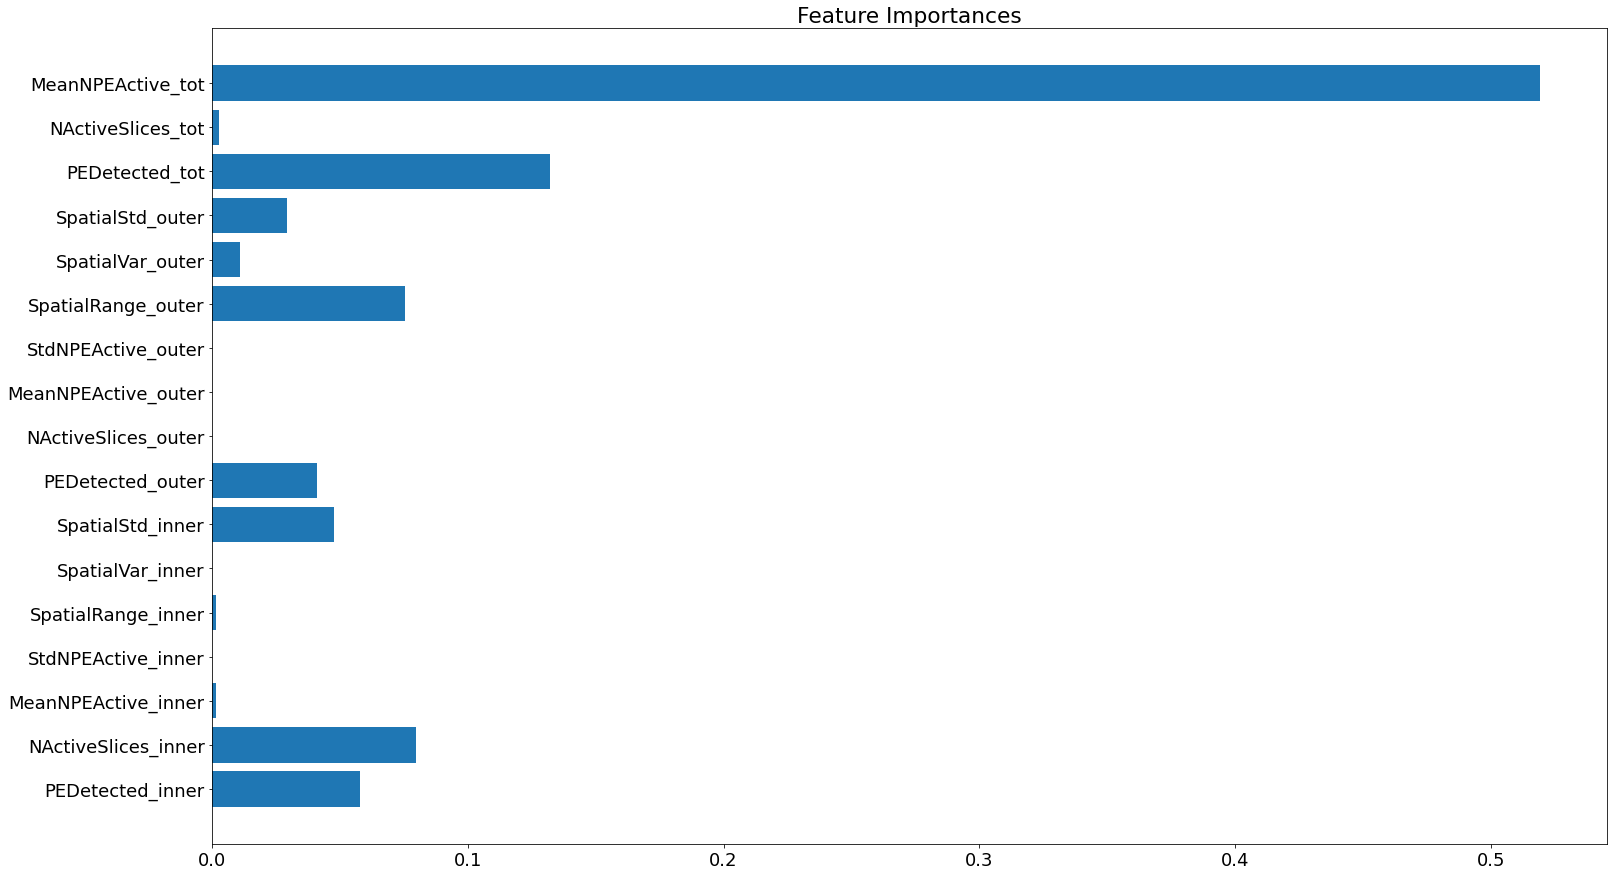

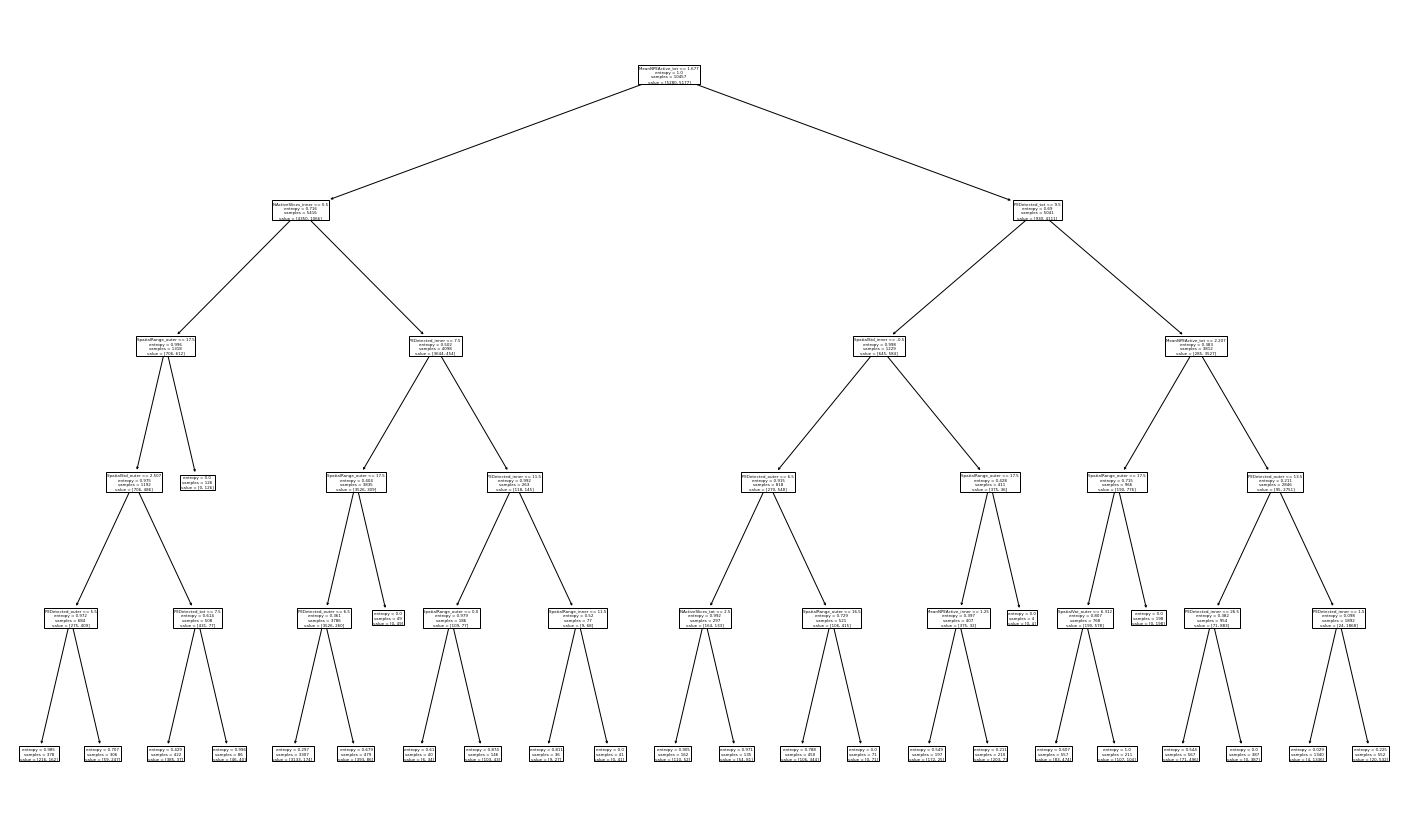

In [34]:
from sklearn import tree

# see feature importances
feature_names = df_ar39_feat.columns[:-1]
importances = clf.feature_importances_
# summarize feature importance
for i, (name, v) in enumerate(zip(feature_names, importances)):
    if(v<=0): 
        continue
    print('Feature: %s =>\tScore: %.5f' % (name, v))
# plot feature importance
plt.barh([x for x in range(len(importances))], importances)
plt.yticks(range(0, len(feature_names)), feature_names)
plt.title("Feature Importances")
plt.show()

tree.plot_tree(clf, feature_names=feature_names)
plt.show()

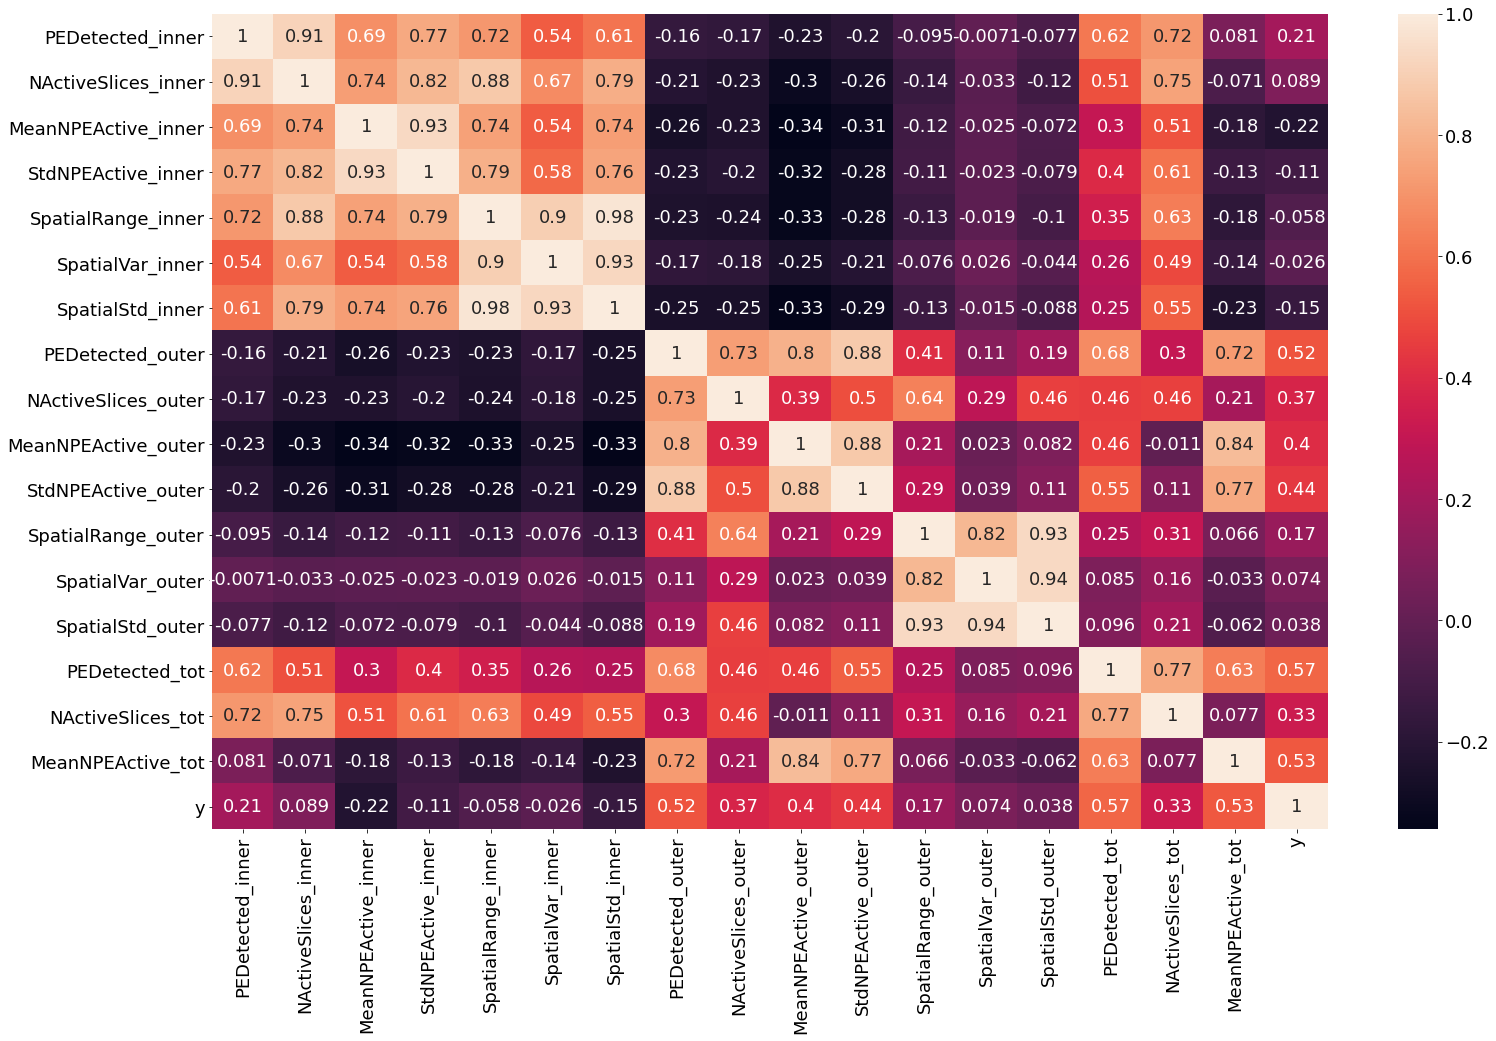

In [35]:
import seaborn as sn

corr_matrix = pd.concat([df_ar41_feat, df_ar39_feat]).corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

# test model on unseen data

In [18]:
# Compute features muon
import time

init = time.time()
df_test_ar41_feat = pd.DataFrame()
df_test_ar41_feat["PEDetected_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["StdNPEActive_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_ar41_feat["SpatialStd_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar41 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["StdNPEActive_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_ar41_feat["SpatialStd_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar41 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_tot"] = df_test_ar41_feat["PEDetected_inner"] + df_test_ar41_feat["PEDetected_outer"]
df_test_ar41_feat["NActiveSlices_tot"] = df_test_ar41_feat["NActiveSlices_inner"] + df_test_ar41_feat["NActiveSlices_outer"]
df_test_ar41_feat["MeanNPEActive_tot"] = df_test_ar41_feat["PEDetected_tot"] / df_test_ar41_feat["NActiveSlices_tot"]
df_test_ar41_feat = df_test_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar41 Inner features: 0.104 sec
Compute Ar41 Outer features: 0.141 sec
Compute combined features: 0.003 sec


In [19]:
# Compute features muon
import time

init = time.time()
df_test_1ar39_feat = pd.DataFrame()
df_test_1ar39_feat["PEDetected_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["StdNPEActive_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_1ar39_feat["SpatialStd_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["StdNPEActive_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_1ar39_feat["SpatialStd_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_tot"] = df_test_1ar39_feat["PEDetected_inner"] + df_test_1ar39_feat["PEDetected_outer"]
df_test_1ar39_feat["NActiveSlices_tot"] = df_test_1ar39_feat["NActiveSlices_inner"] + df_test_1ar39_feat["NActiveSlices_outer"]
df_test_1ar39_feat["MeanNPEActive_tot"] = df_test_1ar39_feat["PEDetected_tot"] / df_test_1ar39_feat["NActiveSlices_tot"]
df_test_1ar39_feat = df_test_1ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 77.029 sec
Compute Ar39 Outer features: 84.715 sec
Compute combined features: 0.039 sec


In [20]:
# Compute features muon
import time

init = time.time()
df_test_2ar39_feat = pd.DataFrame()
df_test_2ar39_feat["PEDetected_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["StdNPEActive_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_2ar39_feat["SpatialStd_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["StdNPEActive_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_2ar39_feat["SpatialStd_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_tot"] = df_test_2ar39_feat["PEDetected_inner"] + df_test_2ar39_feat["PEDetected_outer"]
df_test_2ar39_feat["NActiveSlices_tot"] = df_test_2ar39_feat["NActiveSlices_inner"] + df_test_2ar39_feat["NActiveSlices_outer"]
df_test_2ar39_feat["MeanNPEActive_tot"] = df_test_2ar39_feat["PEDetected_tot"] / df_test_2ar39_feat["NActiveSlices_tot"]
df_test_2ar39_feat = df_test_2ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 129.959 sec
Compute Ar39 Outer features: 156.025 sec
Compute combined features: 0.078 sec


In [21]:
# Compute features muon
import time

init = time.time()
df_test_3ar39_feat = pd.DataFrame()
df_test_3ar39_feat["PEDetected_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["StdNPEActive_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_3ar39_feat["SpatialStd_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["StdNPEActive_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_3ar39_feat["SpatialStd_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_tot"] = df_test_3ar39_feat["PEDetected_inner"] + df_test_3ar39_feat["PEDetected_outer"]
df_test_3ar39_feat["NActiveSlices_tot"] = df_test_3ar39_feat["NActiveSlices_inner"] + df_test_3ar39_feat["NActiveSlices_outer"]
df_test_3ar39_feat["MeanNPEActive_tot"] = df_test_3ar39_feat["PEDetected_tot"] / df_test_3ar39_feat["NActiveSlices_tot"]
df_test_3ar39_feat = df_test_3ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 170.151 sec
Compute Ar39 Outer features: 215.404 sec
Compute combined features: 0.105 sec


In [22]:
# Compute features muon
import time

init = time.time()
df_test_4ar39_feat = pd.DataFrame()
df_test_4ar39_feat["PEDetected_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["StdNPEActive_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_4ar39_feat["SpatialStd_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["StdNPEActive_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_test_4ar39_feat["SpatialStd_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_tot"] = df_test_4ar39_feat["PEDetected_inner"] + df_test_4ar39_feat["PEDetected_outer"]
df_test_4ar39_feat["NActiveSlices_tot"] = df_test_4ar39_feat["NActiveSlices_inner"] + df_test_4ar39_feat["NActiveSlices_outer"]
df_test_4ar39_feat["MeanNPEActive_tot"] = df_test_4ar39_feat["PEDetected_tot"] / df_test_4ar39_feat["NActiveSlices_tot"]
df_test_4ar39_feat = df_test_4ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 175.576 sec
Compute Ar39 Outer features: 225.338 sec
Compute combined features: 0.114 sec


In [23]:
print("[Info] Considering all the available data passing the cut at 5PE:")
print("[Info] Test Set 1 Ar39: {} instances".format(len(df_test_1ar39_feat)))
print("[Info] Test Set 2 Ar39: {} instances".format(len(df_test_2ar39_feat)))
print("[Info] Test Set 3 Ar39: {} instances".format(len(df_test_3ar39_feat)))
print("[Info] Test Set 4 Ar39: {} instances".format(len(df_test_4ar39_feat)))

[Info] Considering all the available data passing the cut at 5PE:
[Info] Test Set 1 Ar39: 461921 instances
[Info] Test Set 2 Ar39: 832101 instances
[Info] Test Set 3 Ar39: 1143980 instances
[Info] Test Set 4 Ar39: 1205004 instances


In [24]:
# create label
df_test_1ar39_feat["y"] = -1    # since label not used, we use it to mark the class of pileup
df_test_2ar39_feat["y"] = -2
df_test_3ar39_feat["y"] = -3
df_test_4ar39_feat["y"] = -4
df_test_ar41_feat["y"] = 1

# data preparation
all_test_data = pd.concat([df_test_1ar39_feat, df_test_2ar39_feat, 
                           df_test_3ar39_feat, df_test_4ar39_feat, df_test_ar41_feat], axis=0)
X, y = all_test_data.iloc[:, :-1], all_test_data.iloc[:, -1]
X = np.array(X)
y = np.where(y<0, 0, 1)
# inference
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)
all_test_data["y_pred"] = y_pred
all_test_data["y_pred_proba"] = y_pred_proba[:, 1]

# evaluate results
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"

print(result_template.format("Test({} Ar41, {} Ar39)".format(len(df_test_ar41_feat), len(y)-len(df_test_ar41_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(720 Ar41, 3643006 Ar39):
Accuracy: 0.743, Precision: 0.001, Recall: 0.843, F1: 0.001

[Result] Conf. Matrix: TN: 2707263, FP: 935743, FN: 113, TP: 607 | TPR: 84.31%, FPR: 25.69%



# looking at each subclass of pileup

In [25]:
fpr_1ar39 = len(all_test_data[(all_test_data.y==-1) & (all_test_data.y_pred==1)]) / len(all_test_data[all_test_data.y==-1])
fpr_2ar39 = len(all_test_data[(all_test_data.y==-2) & (all_test_data.y_pred==1)]) / len(all_test_data[all_test_data.y==-2])
fpr_3ar39 = len(all_test_data[(all_test_data.y==-3) & (all_test_data.y_pred==1)]) / len(all_test_data[all_test_data.y==-3])
fpr_4ar39 = len(all_test_data[(all_test_data.y==-4) & (all_test_data.y_pred==1)]) / len(all_test_data[all_test_data.y==-4])

print("[Info] 1 Ar39: FPR: {:.2f} %".format(fpr_1ar39*100))
print("[Info] 2 Ar39: FPR: {:.2f} %".format(fpr_2ar39*100))
print("[Info] 3 Ar39: FPR: {:.2f} %".format(fpr_3ar39*100))
print("[Info] 4 Ar39: FPR: {:.2f} %".format(fpr_4ar39*100))

[Info] 1 Ar39: FPR: 18.03 %
[Info] 2 Ar39: FPR: 23.42 %
[Info] 3 Ar39: FPR: 26.30 %
[Info] 4 Ar39: FPR: 29.61 %


In [26]:
print(fpr_1ar39 * ar39_fract_pass_cut[0])
print(fpr_2ar39 * ar39_fract_pass_cut[1])
print(fpr_3ar39 * ar39_fract_pass_cut[2])
print(fpr_4ar39 * ar39_fract_pass_cut[3])

0.01570373610709124
0.07349196675983848
0.17016317939324896
0.2690838082538112


# train various classifiers

In [55]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "MLP",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "Logistic Regression"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    MLPClassifier(hidden_layer_sizes=[100, 32]),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression()
]

In [56]:
import time
from sklearn.model_selection import KFold

model_template   = "[Info] Model: {}"
result_template  = "[Info] Complete training in {:.3f} seconds.\n"
result_template += "[Result] Score: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}"
confusion_matrix = "[Info] TN: {}, FP: {}, FN: {}, TP: {}"
# data preparation
df_ar39_feat["y"] = 0
df_ar41_feat["y"] = 1
# data preparation
data = pd.concat([df_ar39_feat, df_ar41_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

# Start kfold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
evaluations = [[] for name in names]
for iteration, (train_ids, test_ids) in enumerate(kf.split(X)):
    print("[Info] KFold - Iteration {}".format(iteration))
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    # iterate over classifiers
    for i, (name, clf) in enumerate(zip(names, classifiers)):
        print("\t" + model_template.format(name))
        start = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = cv(y_test, y_pred).ravel()
        evaluations[i].append({'accuracy': accuracy, 'precision': precision, 'recall': recall})


[Info] KFold - Iteration 0
	[Info] Model: Nearest Neighbors
	[Info] Model: Linear SVM
	[Info] Model: RBF SVM
	[Info] Model: MLP
	[Info] Model: Decision Tree
	[Info] Model: Random Forest
	[Info] Model: AdaBoost
	[Info] Model: Naive Bayes
	[Info] Model: Logistic Regression
[Info] KFold - Iteration 1
	[Info] Model: Nearest Neighbors


/home/luigi/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


	[Info] Model: Linear SVM
	[Info] Model: RBF SVM
	[Info] Model: MLP
	[Info] Model: Decision Tree
	[Info] Model: Random Forest
	[Info] Model: AdaBoost
	[Info] Model: Naive Bayes
	[Info] Model: Logistic Regression
[Info] KFold - Iteration 2
	[Info] Model: Nearest Neighbors


/home/luigi/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


	[Info] Model: Linear SVM
	[Info] Model: RBF SVM
	[Info] Model: MLP
	[Info] Model: Decision Tree
	[Info] Model: Random Forest
	[Info] Model: AdaBoost
	[Info] Model: Naive Bayes
	[Info] Model: Logistic Regression
[Info] KFold - Iteration 3
	[Info] Model: Nearest Neighbors


/home/luigi/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


	[Info] Model: Linear SVM
	[Info] Model: RBF SVM
	[Info] Model: MLP
	[Info] Model: Decision Tree
	[Info] Model: Random Forest
	[Info] Model: AdaBoost
	[Info] Model: Naive Bayes
	[Info] Model: Logistic Regression
[Info] KFold - Iteration 4
	[Info] Model: Nearest Neighbors


/home/luigi/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


	[Info] Model: Linear SVM
	[Info] Model: RBF SVM
	[Info] Model: MLP
	[Info] Model: Decision Tree
	[Info] Model: Random Forest
	[Info] Model: AdaBoost
	[Info] Model: Naive Bayes
	[Info] Model: Logistic Regression


/home/luigi/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
for i in range(len(names)):
    mean_accuracy = np.mean([results["accuracy"] for results in evaluations[i]])
    mean_precision = np.mean([results["precision"] for results in evaluations[i]])
    mean_recall = np.mean([results["recall"] for results in evaluations[i]])
    print("[Info] Model: {}, Mean Results: accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}".format(names[i], mean_accuracy, mean_precision, mean_recall))

[Info] Model: Nearest Neighbors, Mean Results: accuracy: 0.892, precision: 0.903, recall: 0.877
[Info] Model: Linear SVM, Mean Results: accuracy: 0.894, precision: 0.896, recall: 0.888
[Info] Model: RBF SVM, Mean Results: accuracy: 0.714, precision: 0.645, recall: 0.941
[Info] Model: MLP, Mean Results: accuracy: 0.909, precision: 0.912, recall: 0.903
[Info] Model: Decision Tree, Mean Results: accuracy: 0.892, precision: 0.918, recall: 0.859
[Info] Model: Random Forest, Mean Results: accuracy: 0.888, precision: 0.906, recall: 0.864
[Info] Model: AdaBoost, Mean Results: accuracy: 0.903, precision: 0.909, recall: 0.893
[Info] Model: Naive Bayes, Mean Results: accuracy: 0.827, precision: 0.922, recall: 0.711
[Info] Model: Logistic Regression, Mean Results: accuracy: 0.895, precision: 0.901, recall: 0.885


# conclusions
several models deserve a better investigation:
- Linear SVM, DTree, Logistic Regression: easy rule extraction
- Random Forest, AdaBoost: ensemble
- MLP: deep learning
